# Entendimento dos dados

In [74]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler


warnings.filterwarnings('ignore')

In [27]:
data = pd.read_csv(os.getcwd()+'\\data\\raw\\segmentation_data.csv')
data.head(1)

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,100000001,0,0,67,2,124670,1,2


In [28]:
# ajustando nome das colunas
data.columns = data.columns.str.replace(' ', '_').str.lower()

data.head()

,id,sex,marital_status,age,education,income,occupation,settlement_size
0,100000001,0,0,67,2,124670,1,2
1,100000002,1,1,22,1,150773,1,2
2,100000003,0,0,49,1,89210,0,0
3,100000004,0,0,45,1,171565,1,1
4,100000005,0,0,53,1,149031,1,1


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   id               2000 non-null   int64
 1   sex              2000 non-null   int64
 2   marital_status   2000 non-null   int64
 3   age              2000 non-null   int64
 4   education        2000 non-null   int64
 5   income           2000 non-null   int64
 6   occupation       2000 non-null   int64
 7   settlement_size  2000 non-null   int64
dtypes: int64(8)
memory usage: 125.1 KB


In [30]:
data.isnull().sum()

id                 0
sex                0
marital_status     0
age                0
education          0
income             0
occupation         0
settlement_size    0
dtype: int64

In [31]:
data.duplicated().sum()

0

- Os dados apresentam tipagem correta
- Não há dados duplicados nem dados nulos

In [32]:
data.describe()

,id,sex,marital_status,age,education,income,occupation,settlement_size
count,2.000000e+03,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,1.000010e+08,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,5.774946e+02,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,1.000000e+08,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,1.000005e+08,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,1.000010e+08,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000015e+08,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000020e+08,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


# Análise exploratória dos dados

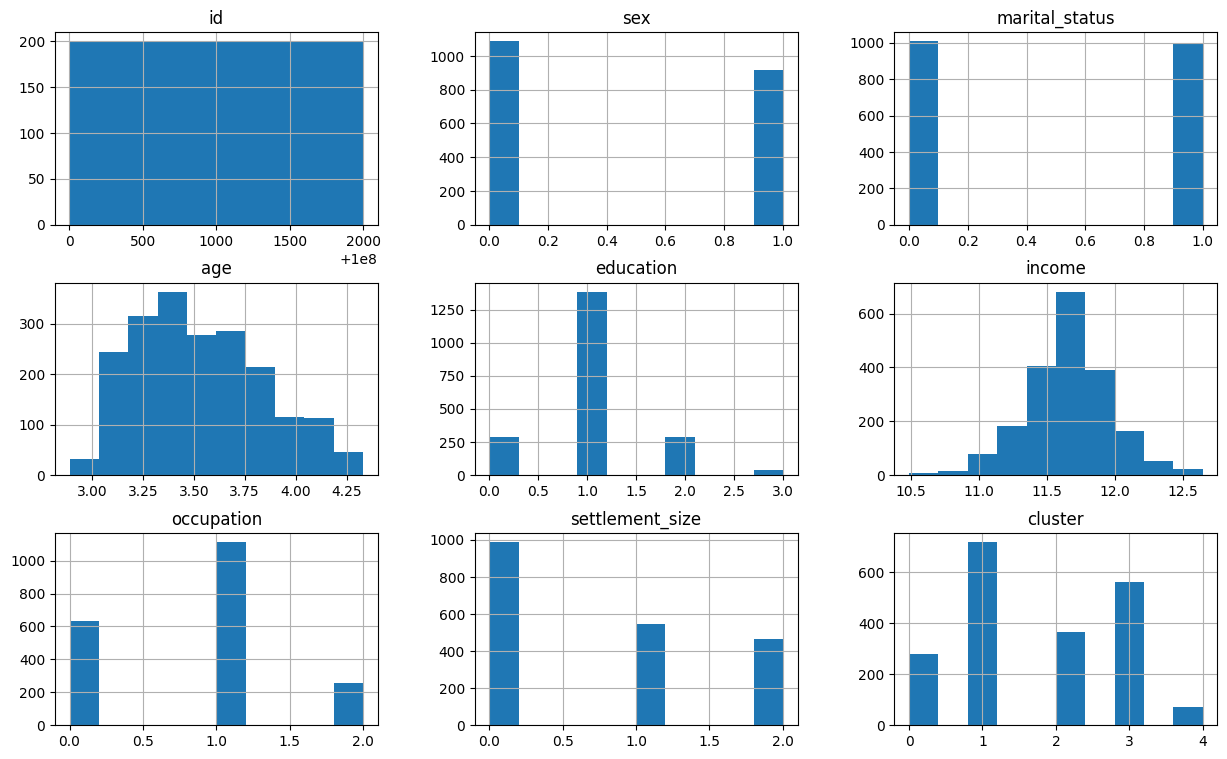

In [51]:
data.hist(figsize=(15,9));

- Analizando préviamente a distribuição dos dados notamos que a coluna `age` e `income` apresentam uma cauda longa e uma certa tentência ao lado esquedo do gráfico. Com o intuito de normalizar essa distribuição utilizaremos o método estatístico de logarítmo a fim de encontra essa normal na distribuição. 
- Este método é utilizado em caso de dados com distribuição desiguais, e funciona diminuindo a escala dos valores.

In [50]:
data['age'] = np.log(data['age'])
data['income'] = np.log(data['income'])

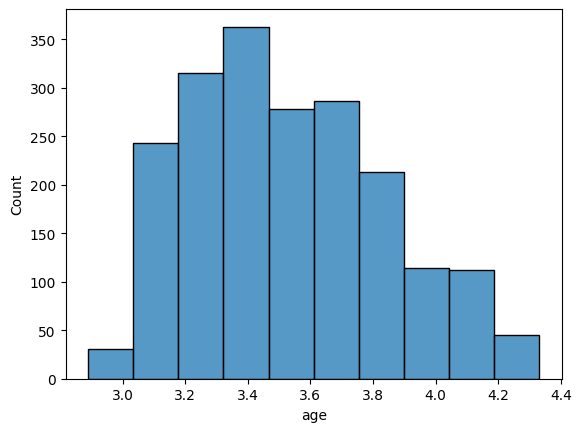

In [52]:
sns.histplot(data['age'], bins=10)
plt.show()

- A maioria dos registros em idade se encontram entre os 25-35 anos.

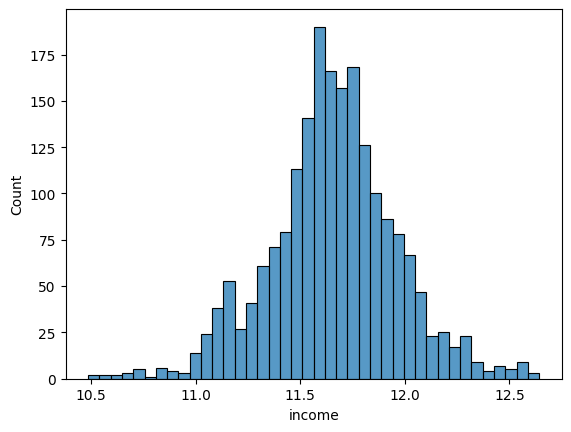

In [53]:
sns.histplot(data['income'])
plt.show()

- A renda média anual é em torno de 100 a 120 mil dólares

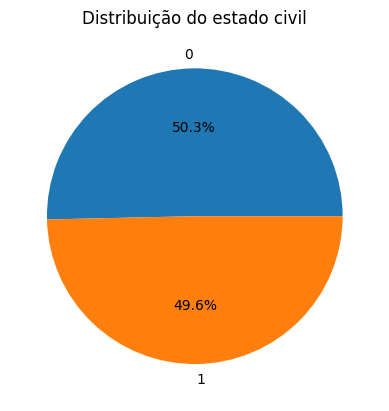

In [54]:
plt.pie(data['marital_status'].value_counts(), labels=data['marital_status'].unique(), autopct='%1.1f%%')
plt.title('Distribuição do estado civil')
plt.show()

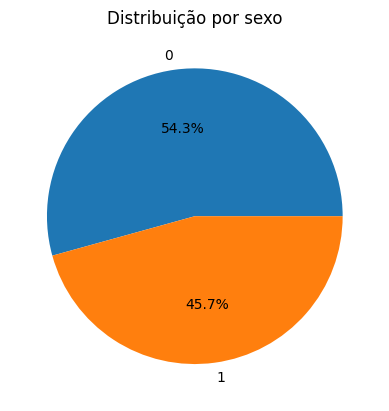

In [55]:
plt.pie(data['sex'].value_counts(), labels=data['sex'].unique(), autopct='%1.1f%%')
plt.title('Distribuição por sexo')
plt.show()

- Há mais homens registrados que mulheres

#### Estado civil  x  Sexo

<Axes: xlabel='marital_status', ylabel='count'>

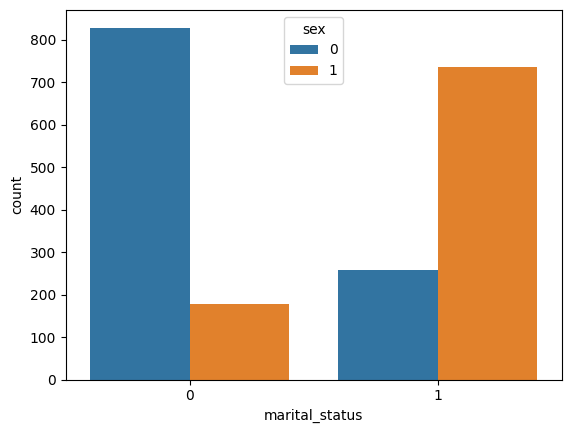

In [56]:
sns.countplot(data=data, x='marital_status', hue='sex')

- Podemos observar que q auntidade de homens solteiros são quase que 4x maior que o número de mulheres solteiras. 
- Já em relacionamento as mulheres apresentam mais que o dobro da quantidade de homens.

<Axes: xlabel='occupation', ylabel='count'>

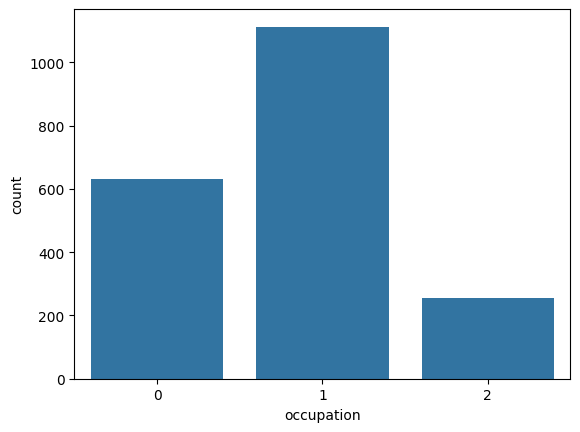

In [57]:
sns.countplot(x='occupation', data=data)

- O maior parte dos nossos clientes são empregados qualificados, em seguida temos os desempregados e por fim altamente qualificados

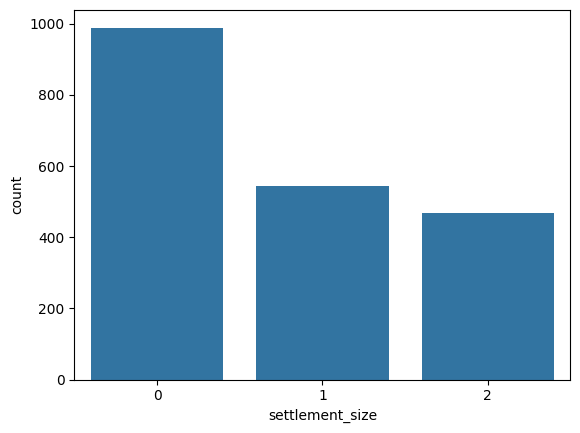

In [58]:
sns.countplot(x='settlement_size', data=data)
plt.show()

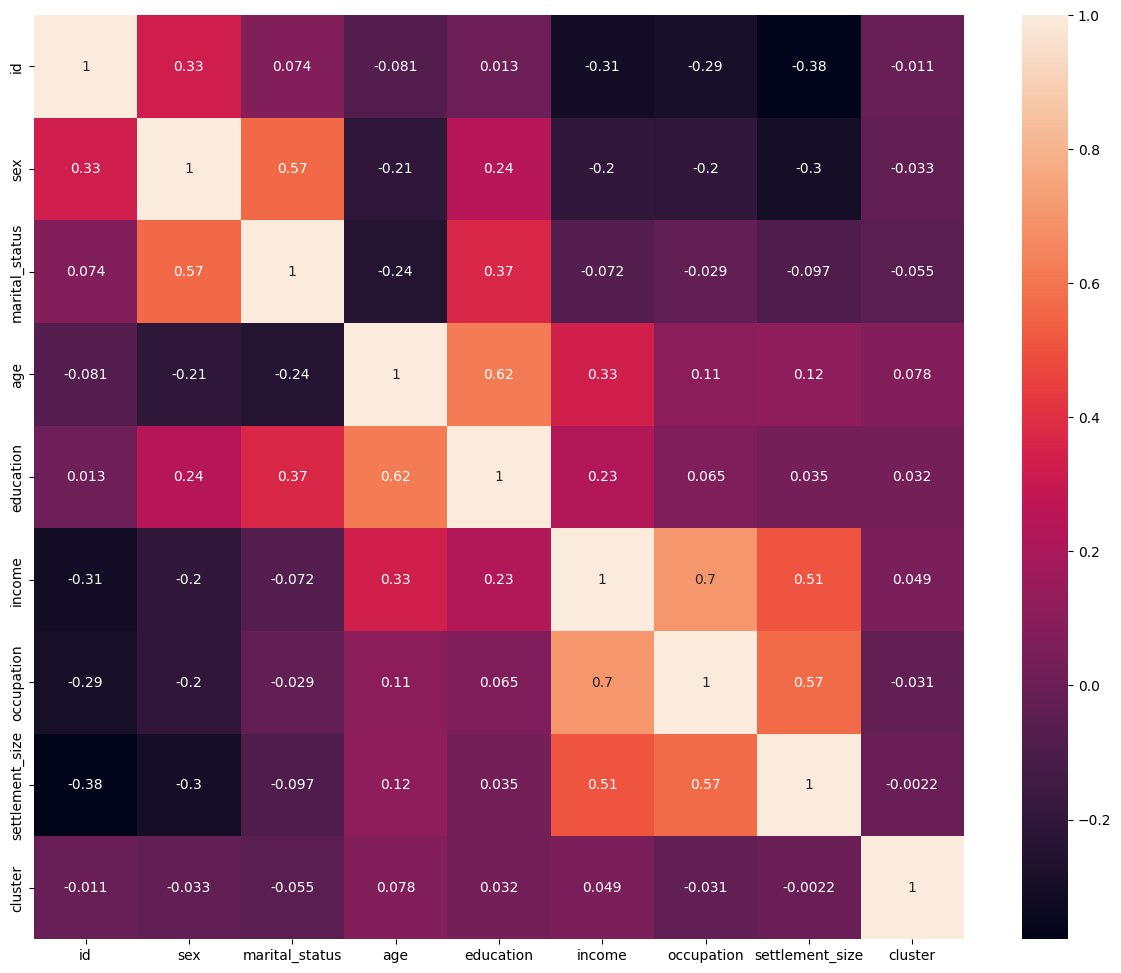

In [59]:
plt.figure(figsize=(15,12))
sns.heatmap(data.corr(), annot=True)
plt.show()

- Notamos uma correlação expressíva entre `occupation` e `income`. O que faz sentido, normalmente quanto maior a renda, melhor a regirão que reside a pessoa. 

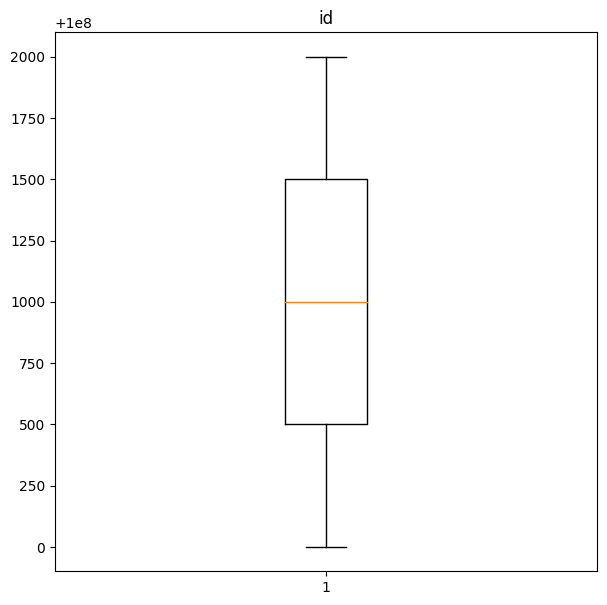

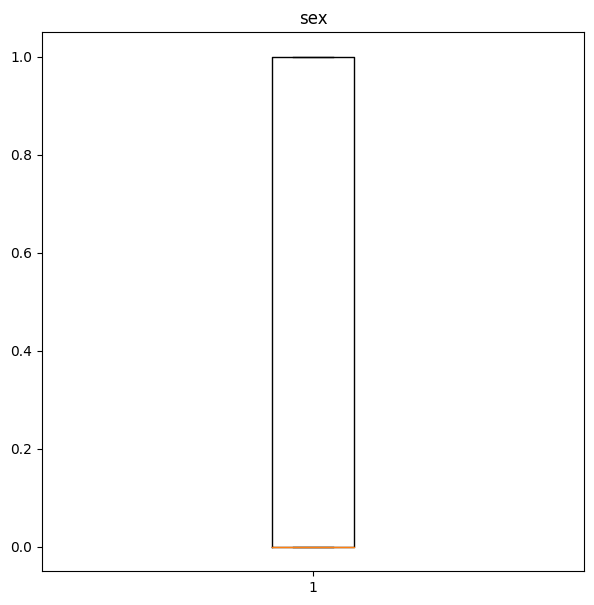

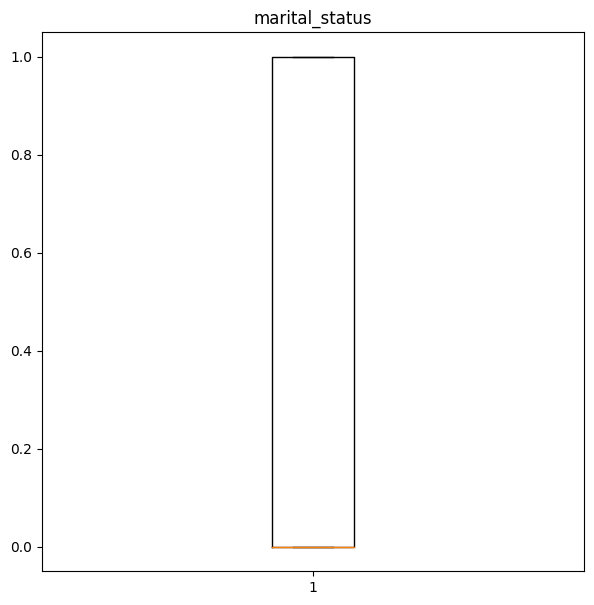

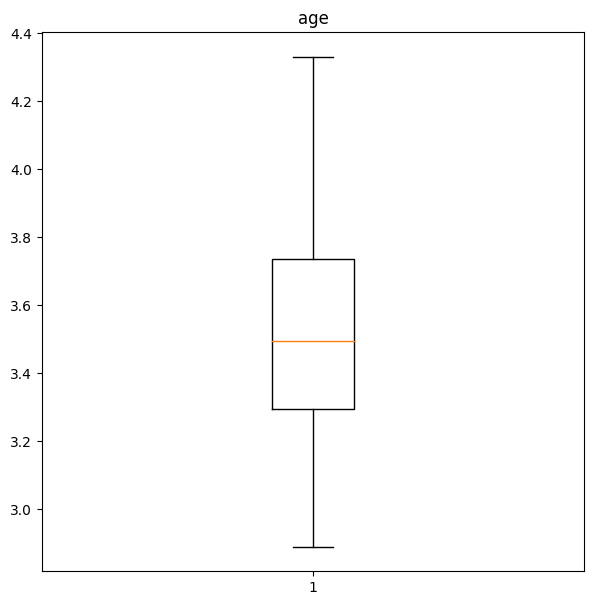

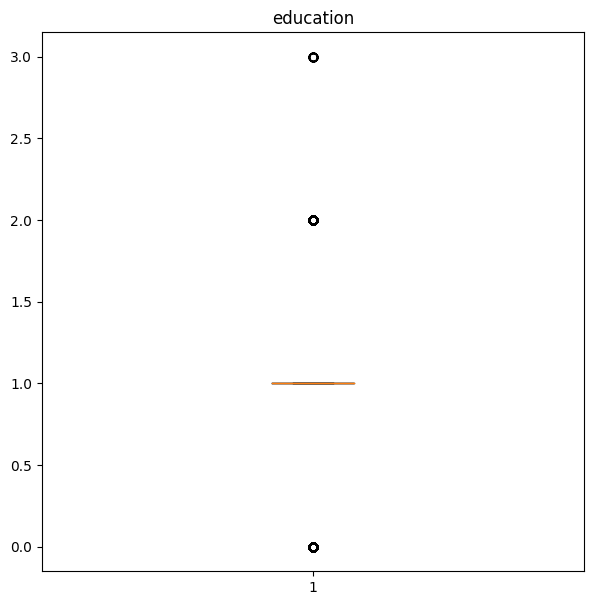

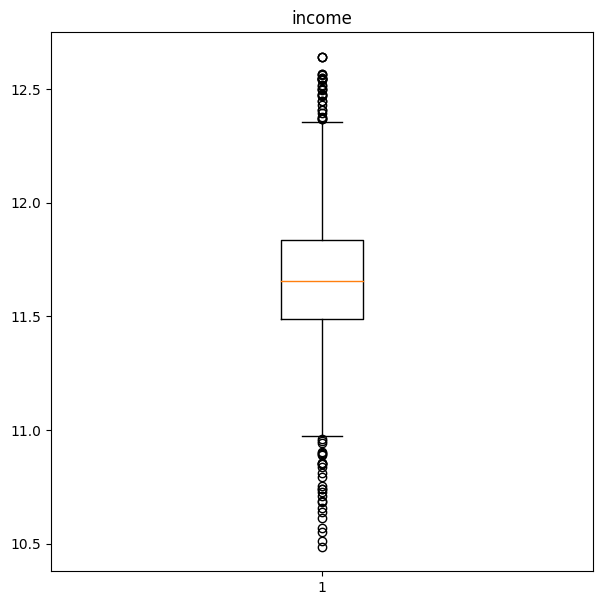

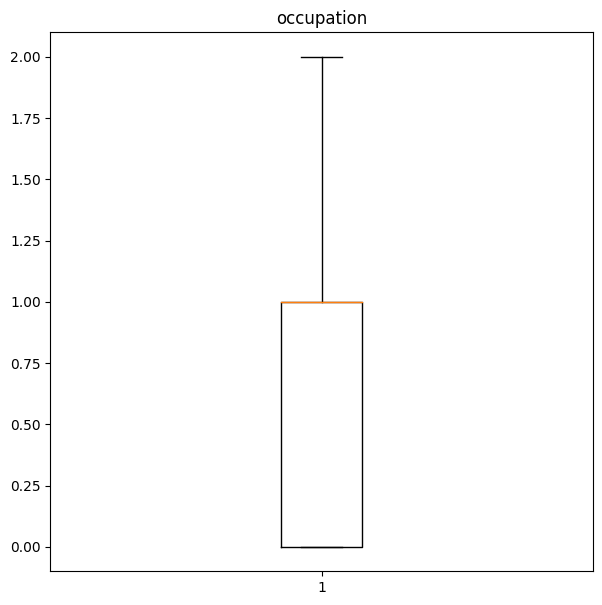

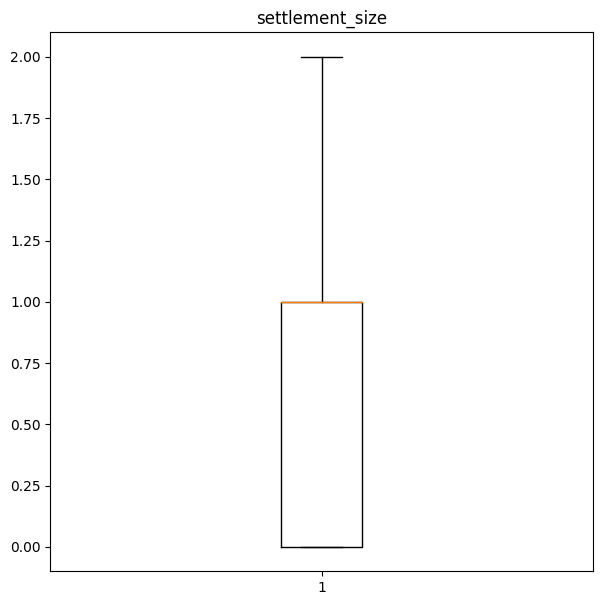

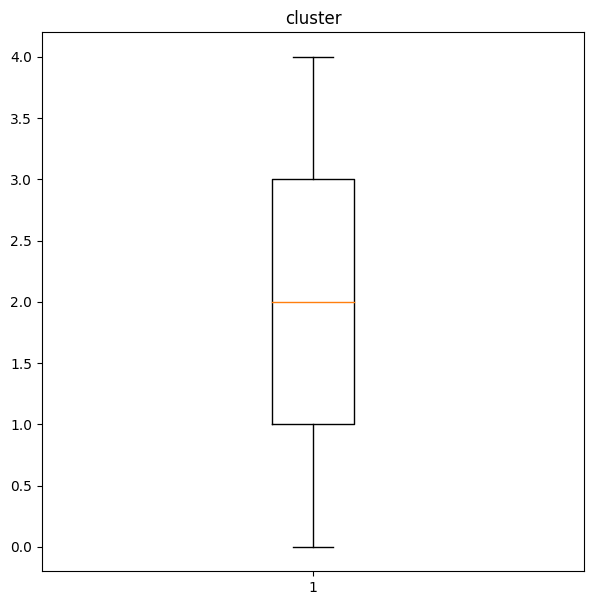

In [60]:
for col in data.columns:
    plt.figure(figsize=(7,7))
    plt.boxplot(data[col])
    plt.title(f'{col}')
    plt.show()

- Nossos dados não possuem outliers

# Modelagem de dados

In [85]:
x = data[['age', 'income', ]]

sc = RobustScaler()

x = sc.fit_transform(x)

x

array([[ 1.60283513,  0.21943558],
       [-0.91768912,  0.76847333],
       [ 0.89471126, -0.74713668],
       ...,
       [-0.14150231, -0.83957083],
       [-0.72075628, -0.47667503],
       [-0.62836387, -1.51359232]])

## K-means

#### Método de cotovelo para determinar o número de K

In [86]:
wcss = []
n_clusters = range(2,15)

for n in n_clusters:
    wcss.append(KMeans(n_clusters = n,init='k-means++', random_state=42).fit(x).inertia_)

In [87]:
wcss

[1422.6312066630917,
 1045.6872422096417,
 803.0832189838573,
 647.5144764470252,
 542.6184904361421,
 456.74260382100954,
 407.46010677082086,
 366.75989308926825,
 328.260786352658,
 303.6887489389536,
 277.23793987526835,
 257.35718884872153,
 240.9327538404249]

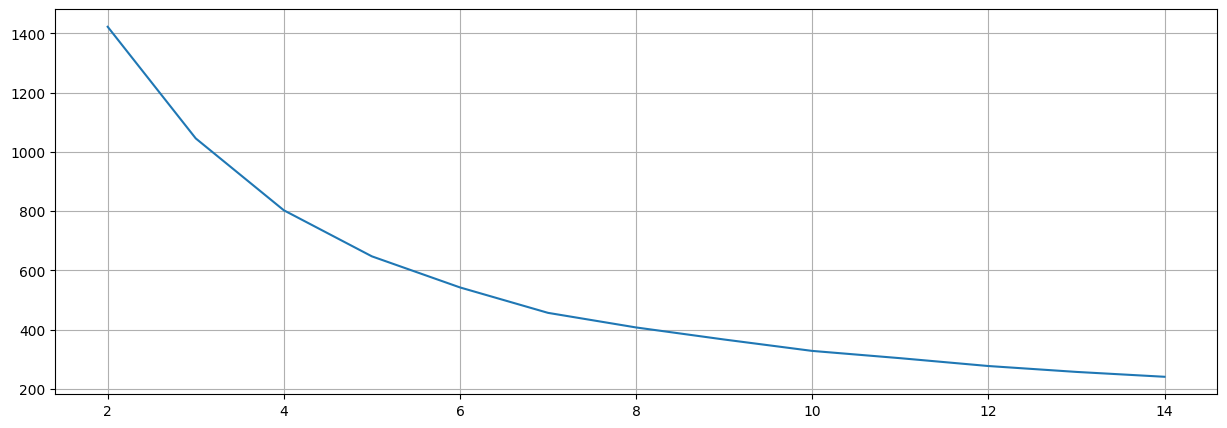

In [88]:
plt.figure(figsize=(15,5))
plt.plot(n_clusters, wcss)
plt.grid()
plt.show()

- Podemos observar que o melhor valor de K é 4 grupos. Para este estudo usaremos 4, caso fosse um projeto real contactaria-mos com o time de negócios para determinar estes valores.

In [92]:
km = KMeans(n_clusters=4, random_state=42)
x_trasf = km.fit_predict(x)
x_trasf

array([1, 3, 1, ..., 2, 3, 2])

In [93]:
data.loc[:,'cluster'] = x_trasf
data

,id,sex,marital_status,age,education,income,occupation,settlement_size,cluster
0,100000001,0,0,4.204693,2,11.733426,1,2,1
1,100000002,1,1,3.091042,1,11.923531,1,2,3
2,100000003,0,0,3.891820,1,11.398748,0,0,1
3,100000004,0,0,3.806662,1,12.052717,1,1,0
4,100000005,0,0,3.970292,1,11.911910,1,1,0
...,...,...,...,...,...,...,...,...,...
1995,100001996,1,0,3.850148,1,11.724199,0,0,1
1996,100001997,1,1,3.295837,1,11.676268,1,0,3
1997,100001998,0,0,3.433987,0,11.366743,0,0,2
1998,100001999,1,1,3.178054,1,11.492396,0,0,3


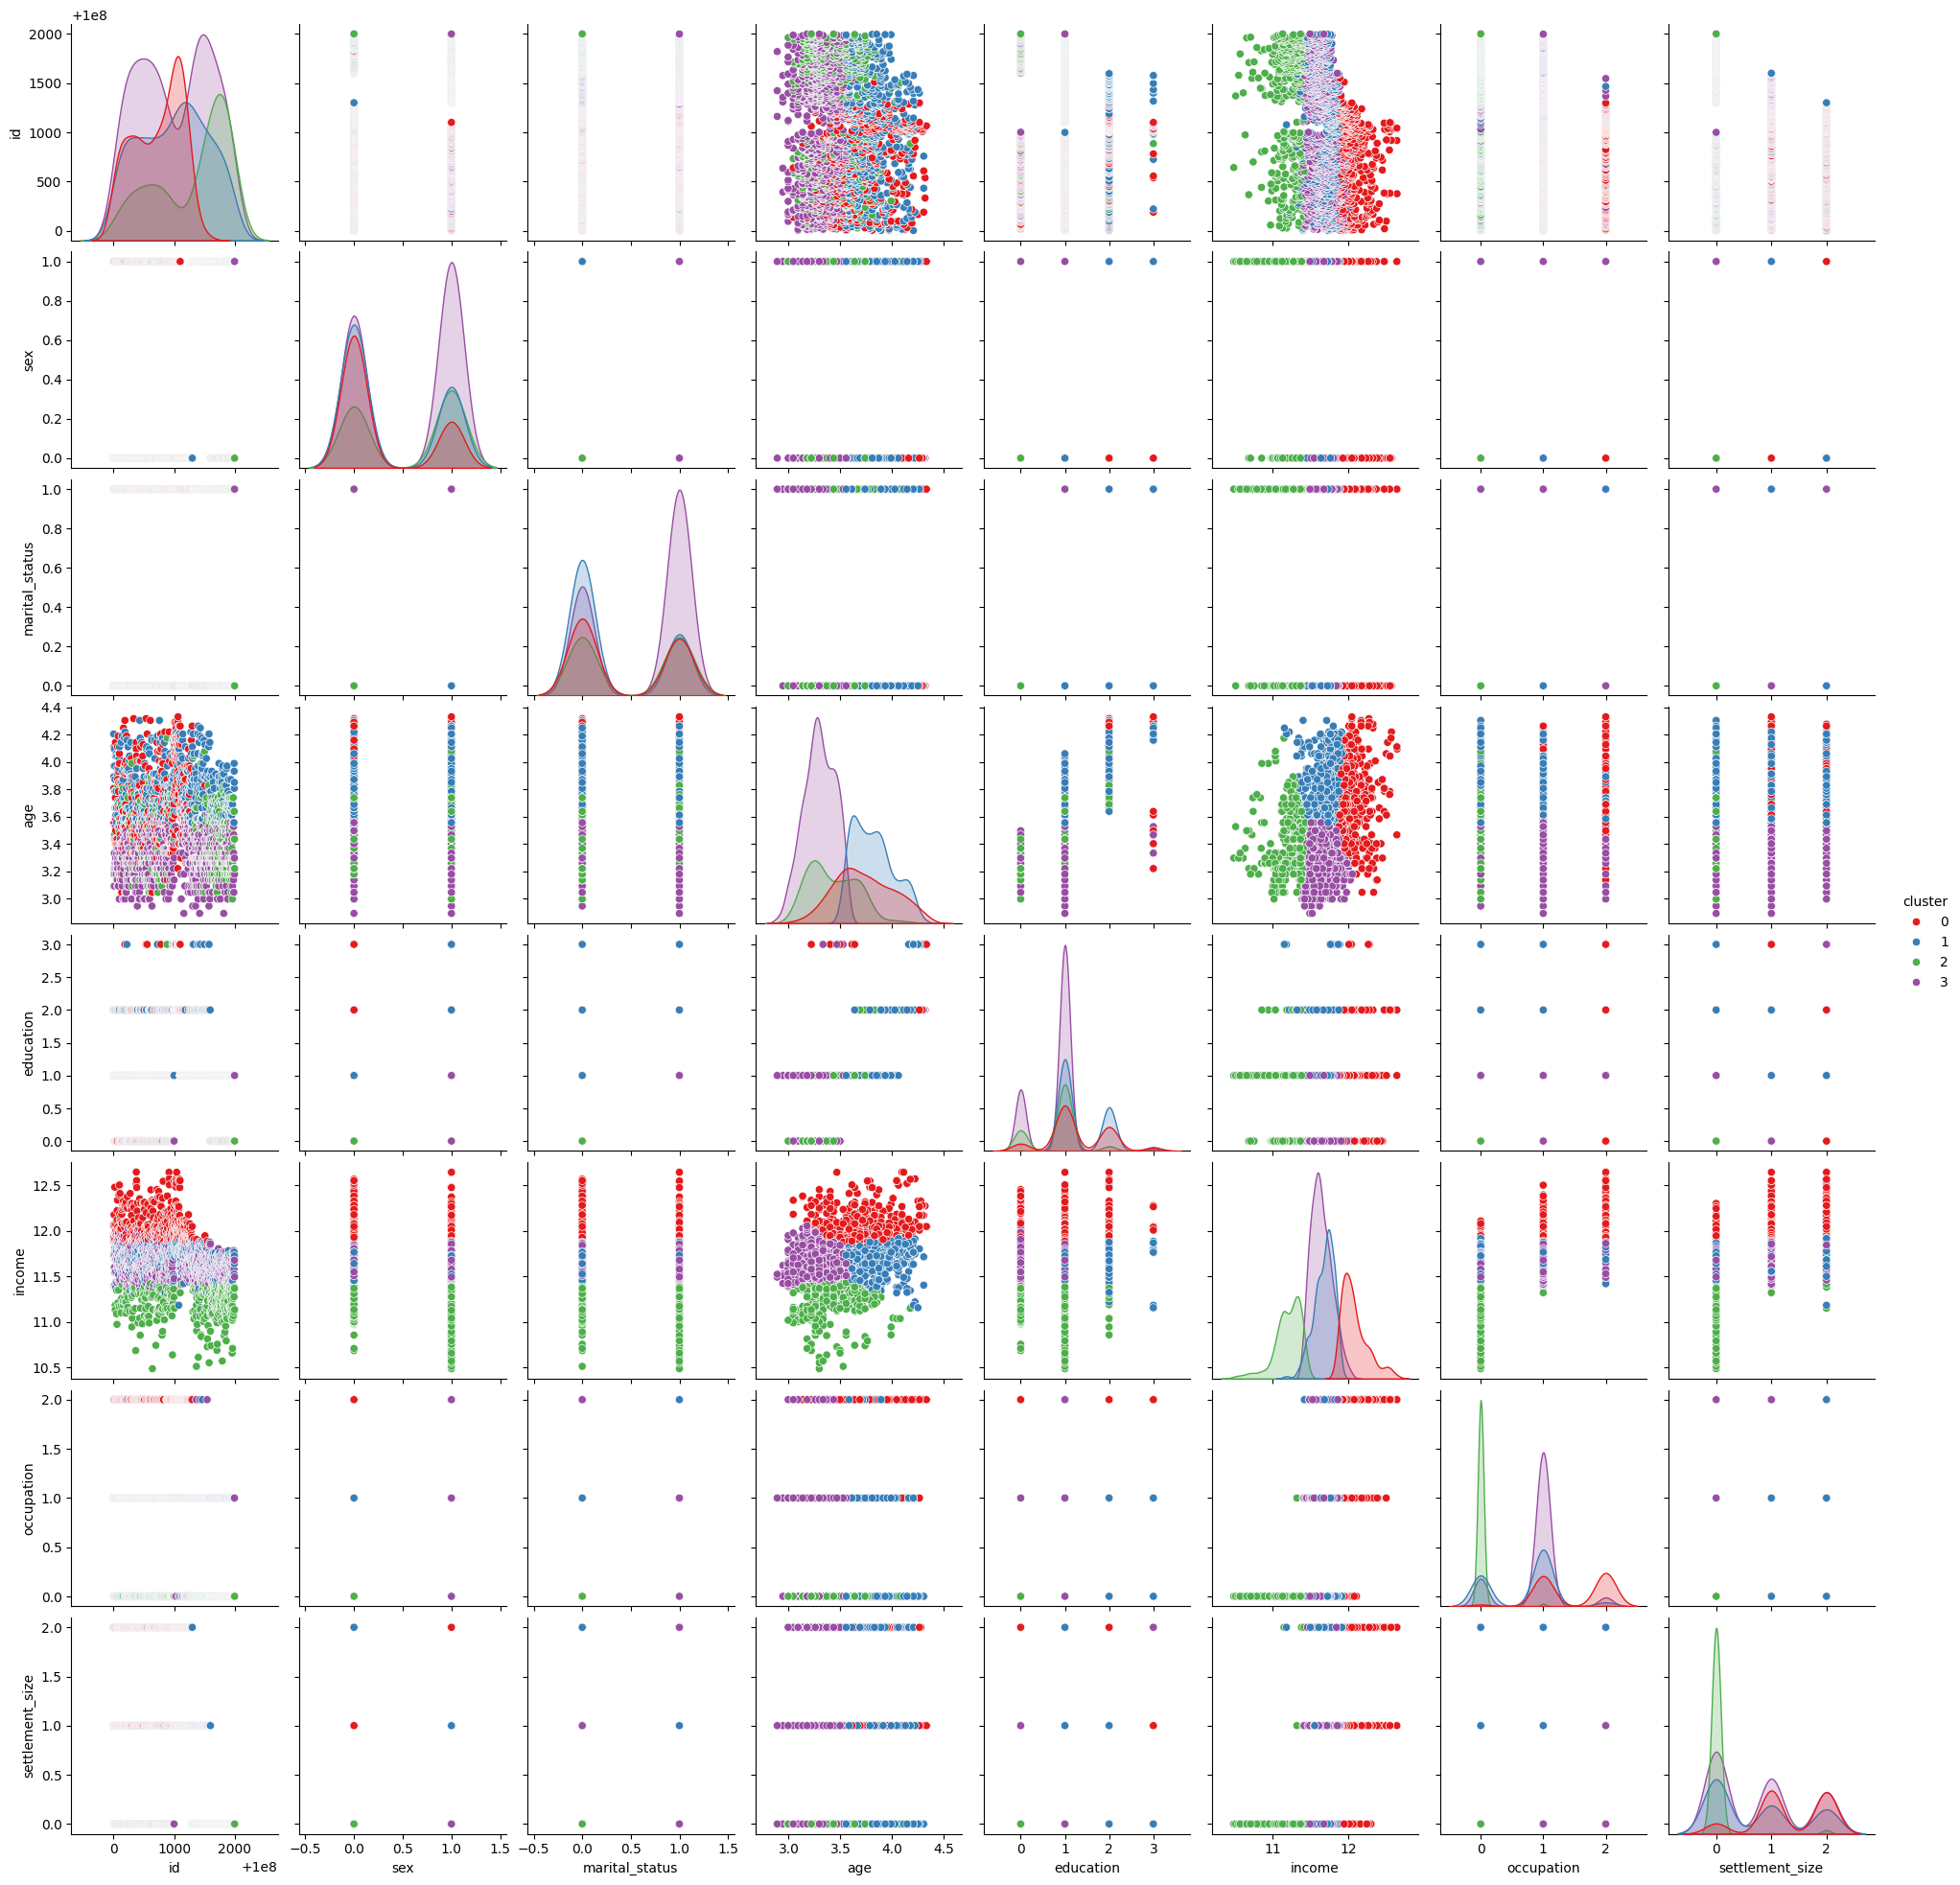

In [94]:
sns.pairplot(data, hue='cluster', palette='Set1')
plt.show()